In [10]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import RandomizedPCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('misconduct.csv', header=False)
df = df.dropna(subset=['Misconduct Description', 'Action'])

In [4]:
#Manual hierarchical clustering?

for x in ['surrender', 'revoked','revoke', 'surrendered',
          'Surrender', 'Revoked', 'Revoke', 'Revocation', 'revocation',
          'Surrendered']:
    df.loc[df['Action'].str.contains(x), 'Action'] = 'lost license'


for x in ['dismissed', 'dropped', 'Dismissed', 'Dropped', 'No penalty']:
    df.loc[df.Action.str.contains(x), 'Action'] = 'dropped'

for x in ['fine', 'Fined', 'Fine', 'fined']:
    df.loc[df.Action.str.contains(x), 'Action'] = 'fine'

for x in ['Suspension', 'suspension']:
    df.loc[df.Action.str.contains(x), 'Action'] = 'suspension'
    
df.loc[df.Action.str.len() > 12] = 'reprimand'
df.loc[df.Action == 'Reprimand'] = 'reprimand'

In [5]:
pd.unique(df['Action'])

array(['lost license', 'reprimand', 'fine', 'suspension', 'dropped'], dtype=object)

In [6]:
#train test splitting

X_full = list(df['Misconduct Description'])
y_full = list(df['Action'])

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,
                                                    train_size=.8, random_state=19)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [14]:
#Creating the pipeline
stop_words = ('the', 'in', 'a','he','she', 'at', 'physician')

full_clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=13,
                                                  weights='distance'))])

In [16]:

full_clf.fit(np.asarray(X_train), np.asarray(y_train))
print 'accuracy: {}'.format(np.mean(full_clf.predict(X_test) == y_test))

accuracy: 0.767605633803


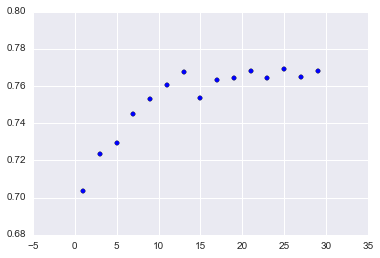

In [17]:
#Find the best k (without grid search, so we can plot)

ks = []
accuracy = []


for k in range(1,31,2):
    ks.append(k)
    full_clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', KNeighborsClassifier(n_neighbors=k,
                                                      weights='distance'))])  
    full_clf.fit(X_train, y_train)    
    accuracy.append(np.mean(full_clf.predict(X_test) == y_test))
plt.scatter(ks, accuracy)

Normalized confusion matrix
[[ 0.66666667  0.          0.          0.          0.33333333]
 [ 0.          0.59663866  0.22689076  0.          0.17647059]
 [ 0.00603136  0.12183353  0.73220748  0.          0.13992762]
 [ 0.          0.          0.          1.          0.        ]
 [ 0.          0.16239316  0.33333333  0.          0.5042735 ]]


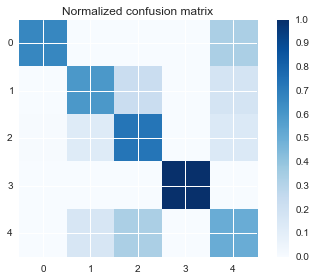

In [21]:
cm = confusion_matrix(full_clf.predict(X_test), y_test)

#function for ploting normalized confusion matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')